In [1]:
import logging
import sys
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt

from simsopt.field.boozermagneticfield import (
        BoozerRadialInterpolant,
        InterpolatedBoozerField,
        ShearAlfvenHarmonic,
        ShearAlfvenWavesSuperposition
        )
from simsopt._core.util import parallel_loop_bounds
from simsopt.field.tracing import (
        MaxToroidalFluxStoppingCriterion,
        MinToroidalFluxStoppingCriterion,
        IterationStoppingCriterion,
        trace_particles_boozer_perturbed
)
from simsopt.util.constants import (
        ALPHA_PARTICLE_MASS as MASS,
        ALPHA_PARTICLE_CHARGE as CHARGE,
        FUSION_ALPHA_PARTICLE_ENERGY as ENERGY
)
from simsopt.util.constants import ALPHA_PARTICLE_MASS, ALPHA_PARTICLE_CHARGE, FUSION_ALPHA_PARTICLE_ENERGY
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d
import stellgap as sg
from scipy import integrate
from matplotlib.cm import ScalarMappable
import simsoptpp as sopp


[login13:1292557] mca_base_component_repository_open: unable to open mca_btl_openib: /usr/lib64/libnl-3.so.200: version `libnl_3_5' not found (required by /global/homes/b/billert/.conda/envs/poincare_testing/lib/openmpi/.././libnl-route-3.so.200) (ignored)


In [2]:
import simsoptpp as sopp

bump_multi = 0.0

filename = 'boozmn_precise_QH.nc'
ic_folder = 'initial_conditions'

saw_filename = 'mode/scaled_mode_32.935kHz.npy'
saw_data = np.load(saw_filename, allow_pickle=True)
saw_data = saw_data[()]
saw_omega = 1000*np.sqrt(saw_data['eigenvalue'])
print("omega=", saw_omega)
s = saw_data['s_coords']
saw_srange = (s[0], s[-1], len(s))
saw_m = np.ascontiguousarray([x[0] for x in saw_data['harmonics']])
saw_n = np.ascontiguousarray([x[1] for x in saw_data['harmonics']])
saw_phihats = bump_multi * np.ascontiguousarray(np.column_stack([x[2].T for x in saw_data['harmonics']]))
saw_nharmonics = len(saw_m)

logging.basicConfig()
logger = logging.getLogger('simsopt.field.tracing')

t1 = time.time()
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(filename)
nfp = equil.nfp

s_init = np.loadtxt(f's_init_poinc.txt', ndmin=1)
theta_init = np.loadtxt(f'chis_init_poinc.txt', ndmin=1)
zeta_init = np.loadtxt(f'chis_init_poinc.txt', ndmin=1)
vpar_init = np.zeros(len(s_init)) + np.sqrt(2*ENERGY/MASS)
# s_init = s_init[:1]
# theta_init = theta_init[:1]
# zeta_init = zeta_init[:1]
# vpar_init = vpar_init[:1]
points = np.zeros((s_init.size, 3))
points[:, 0] = s_init
points[:, 1] = theta_init
points[:, 2] = zeta_init
points = np.ascontiguousarray(points)
vpar_init = np.ascontiguousarray(vpar_init)


omega= 32935.740465336436


In [3]:
bri = BoozerRadialInterpolant(
    equil=equil,
    order=3,
    no_K=False
)

degree = 3
srange = (0, 1, 15)
thetarange = (0, np.pi, 15)
zetarange = (0, 2*np.pi/nfp, 15)

field = InterpolatedBoozerField(
    bri,
    degree=3,
    srange=(0, 1, 15),
    thetarange=(0, np.pi, 15),
    zetarange=(0, 2*np.pi/nfp, 15),
    extrapolate=True,
    nfp=nfp,
    stellsym=True,
    initialize=['modB','modB_derivs']
)

# Evaluate error in interpolation
print('Error in |B| interpolation', 
    field.estimate_error_modB(1000),
    flush=True)

VELOCITY = np.sqrt(2*ENERGY/MASS)

# set up GPU interpolation grid
def gen_bfield_info(field, srange, trange, zrange):

	s_grid = np.linspace(srange[0], srange[1], srange[2])
	theta_grid = np.linspace(trange[0], trange[1], trange[2])
	zeta_grid = np.linspace(zrange[0], zrange[1], zrange[2])

	quad_pts = np.empty((srange[2]*trange[2]*zrange[2], 3))
	for i in range(srange[2]):
		for j in range(trange[2]):
			for k in range(zrange[2]):
				quad_pts[trange[2]*zrange[2]*i + zrange[2]*j + k, :] = [s_grid[i], theta_grid[j], zeta_grid[k]]


	field.set_points(quad_pts)
	G = field.G()
	iota = field.iota()
	diotads = field.diotads()
	I = field.I()
	modB = field.modB()
	J = (G + iota*I)/(modB**2)
	maxJ = np.max(J) # for rejection sampling

	psi0 = field.psi0

	# Build interpolation data
	modB_derivs = field.modB_derivs()

	dGds = field.dGds()
	dIds = field.dIds()

	quad_info = np.hstack((modB, modB_derivs, G, dGds, I, dIds, iota, diotads))
	quad_info = np.ascontiguousarray(quad_info)

	return quad_info, maxJ, psi0

# generate grid with 15 simsopt grid pts
n_grid_pts = 15
srange = (0, 1, 3*n_grid_pts+1)
trange = (0, np.pi, 3*n_grid_pts+1)
zrange = (0, 2*np.pi/nfp, 3*n_grid_pts+1)
quad_info, maxJ, psi0 = gen_bfield_info(field, srange, trange, zrange)

nparticles = len(points)

Error in |B| interpolation (6.327560498512313e-05, 8.579600348910538e-05)


In [4]:
helicity = -1
zetas = [0]
Phim = 17
Phin = -17
omega = 32935.0
omegas = [omega/(Phin - Phim*helicity*nfp)]

In [5]:
first_two_points = points
first_two_vpar_init = vpar_init
nparticles = len(first_two_points)

In [46]:
last_time = sopp.poincare_plotting(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=first_two_points,
	m=MASS, 
	q=CHARGE, 
	vtotal=VELOCITY,  
	vtang=first_two_vpar_init, 
	tmax=1e-2, 
	tol=1e-8, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6, MAX_PUNCTURES=1000, zetas=zetas, omegas=omegas)

In [47]:
last_time = np.reshape(last_time, (-1, 5))
last_time[:2] = last_time[:2] % (2 * np.pi)
hits = (last_time[~(last_time == 0).all(1)])
# print(hits)
print(len(hits))
print((hits[:, 2] % (2 * np.pi)) % (2 * np.pi))

19000
[5.44053767e-03 1.09092907e-02 1.63815808e-02 ... 5.44439400e+00
 5.44978898e+00 5.45521413e+00]


In [48]:
print(np.shape(np.where(np.isclose(hits[:, 2] % (2 * np.pi), 0))))

(1, 0)


NameError: name 'hits' is not defined

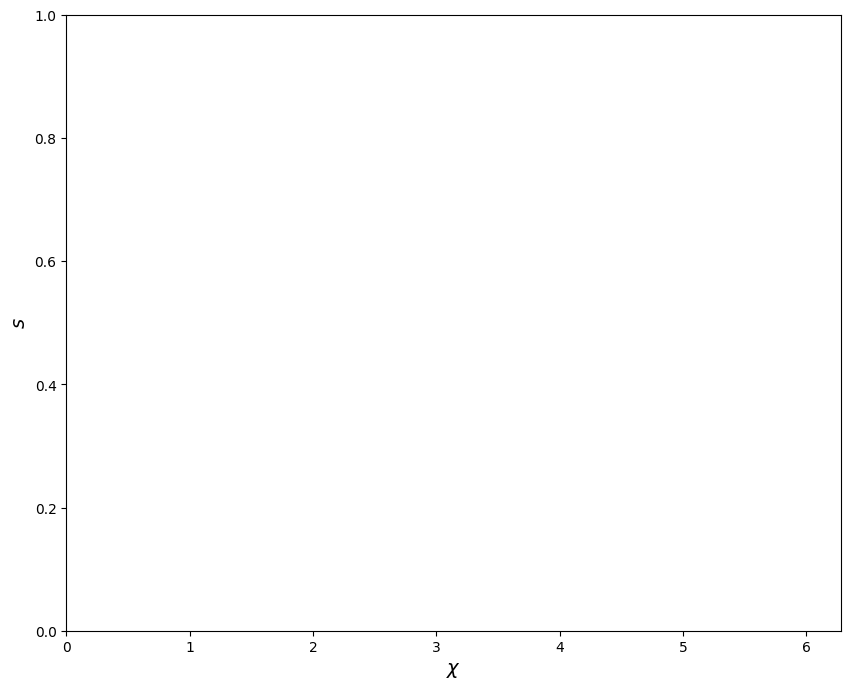

In [6]:
plt.figure(1, figsize=(10, 8))
plt.xlabel(r'$\chi$', fontsize=14)
plt.ylabel(r'$s$', fontsize=14)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 1])
s_hits = hits[:, 0]
helicity = -1
chi_hits = (hits[:, 1] - nfp * helicity * hits[:, 2]) % (2 * np.pi)
theta_hits = (hits[:, 1] + 2*np.pi) % (2 * np.pi) - np.pi
plt.scatter(chi_hits, s_hits, s=2, edgecolors='none', marker='o')